The code should run as given

In [15]:
%matplotlib inline

import torch
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

import random
import numpy as np
import matplotlib.pyplot as plt
import helper
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
test =123

In [7]:
def set_seed(n):
    torch.backends.cudnn.deterministic = True
    random.seed(n)
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)
    np.random.seed(n)

set_seed(1)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


### Load data from our repo

In [9]:
!git clone https://github.com/s-n-naik/Athena_Hack_2021.git

Cloning into 'Athena_Hack_2021'...
remote: Enumerating objects: 1275, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 1275 (delta 92), reused 107 (delta 55), pack-reused 1130
Receiving objects: 100% (1275/1275), 1.16 GiB | 46.61 MiB/s, done.
Resolving deltas: 100% (155/155), done.
Checking out files: 100% (1005/1005), done.


In [27]:
transform = transforms.Compose([
     transforms.Resize(100),
     transforms.CenterCrop(100),                                             
     transforms.ToTensor(),
     #transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),),                        
])

NUM_TRAIN = 700
NUM_VAL = 100

# classes: carboard, glass, metal, paper, plastic, trash
# 2527 samples
# NOTE: if we want separate transforms for train & test (which we prob do),
#       we'll have to do this differently
dataset= datasets.ImageFolder('Athena_Hack_2021/image_classifier', transform=transform)

dataloader_train = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(range(0, NUM_TRAIN)))
dataloader_val = torch.utils.data.DataLoader(dataset, batch_size=100, sampler=SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN+NUM_VAL)))
dataloader_test = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(range(NUM_TRAIN+NUM_VAL, len(dataset))))
dataloader_image = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(range(NUM_TRAIN+NUM_VAL, len(dataset))))

### Model and training

In [39]:

import logging

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

logger = logging.getLogger()

class SimpleClassifier_1_hidden_layer(nn.Module):
    """
     Fully connected NN binary classifier with 1 hidden layer  
        :param input_features:
        :param output_features:
        :return: NN object
    """
    def __init__(self, img_size, output_features=1, n_hidden=100, channels=3):
        super().__init__()
        self.input_features = channels * img_size * img_size
        self.output_features = output_features
        self.linear1 = nn.Linear(
            in_features=self.input_features, out_features=n_hidden, bias=True
        )
        self.linear2 = nn.Linear(
            in_features=n_hidden, out_features=output_features, bias=True 
        )

    def forward(self, inputs):
        h = self.linear1(inputs.view(-1, self.input_features)) 
        h = F.relu(h)
        h = self.linear2(h)
        return torch.sigmoid(h)


class ResNet_Classifier(nn.Module):
    def __init__(self, output_features=1, use_pretrained=True):
        """ Resnet-38 binary classifier class pre-trained on ImageNet dataset.
        """
        super().__init__()
        self.model = torchvision.models.resnet34(pretrained=use_pretrained)
        # in feature extraction mode, we set the requires_grad = False for all params
        num_ftrs = self.model.fc.in_features
        # then we create a new linear layer
        # params of this layer will automatically have the requires_grad attribute set to True
        self.model.fc = nn.Linear(num_ftrs, output_features)
        self.input_size = 100

    def forward(self, inputs):
        h = self.model(inputs)
        return torch.sigmoid(h)


def train(model, train_loader, optimizer, no_epochs, device, log_interval=10, weighted_loss = False,
          class_proportions=None):
    """
    A utility function that performs a basic training loop.

    For each batch in the training set, fetched using `train_loader`:
        - Zeroes the gradient used by `optimizer`
        - Performs forward pass through `model` on the given batch
        - Computes loss on batch
        - Performs backward pass
        - `optimizer` updates model parameters using computed gradient
    """

    model.train()
    if weighted_loss:
        assert class_proportions is not None, "Must provide class_weights dict to use weighted loss"
        logger.info(f"Training with weighted loss function")

    for epoch in range(no_epochs):
        total_loss= 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.float().to(device)
            if weighted_loss:
                weights = targets.detach().clone()
                # counts is a tuple (tensor of classes, tensor of corresponding counts)
                counts = weights.unique(return_counts=True)
                # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
                # weights for F.binary_cross_entropy needs to be the same shape as targets with the correct weight per entry

                for idx in range(len(counts[0])):
                    idx = int(idx)
                    target = int(counts[0][idx].item())
                    if target == 1:
                        class_weight = 1/ class_proportions["yes_red_car"]
                    elif target == 0:
                        class_weight = 1/ class_proportions["no_red_car"]
                    # go through the classes in the batch
                    # for values in the target tensor which have class 0/1, replace with inverse proportion for that class
                    weights[weights == counts[0][idx]] = class_weight

            else:
                weights = None


            optimizer.zero_grad()

            outputs = model(inputs).float()

            # reduction = mean gives weighted average loss if weights are used
            loss = F.binary_cross_entropy(outputs.squeeze(-1), targets, weight=weights, reduction="mean")
            total_loss +=loss
            
  
            loss.backward()

            optimizer.step()
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, total_loss / len(train_loader.dataset)))


def validate(model, val_loader, device):
    """
    A utility function to compute the loss and accuracy on a test set by
    iterating through the test set using the provided `test_loader` and
    accumulating the loss and accuracy on each batch.
    return: accuracy of model on validation dataset
    """
    correct = 0
    denominator = 0
    model.eval()
    with torch.no_grad(): 
        for inputs, targets in val_loader:
            denominator += len(targets)
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs).squeeze(-1)
            pred = outputs>0.5
            pred = pred.long()
            correct += pred.eq(targets.view_as(pred)).sum().item()

    accuracy = correct / denominator
    #print(accuracy)
    return accuracy




In [41]:
# 10 epochs = 20 mins
model = SimpleClassifier_1_hidden_layer(100)
model = model.to(device)
learning_rate = 5.13e-03
optimizer = torch.optim.Adam(model_cls.parameters(), lr=learning_rate)
train(model, dataloader_train, optimizer, 10, 'cuda')

====> Epoch: 0 Average loss: 0.0161
====> Epoch: 1 Average loss: 0.0161
====> Epoch: 2 Average loss: 0.0161
====> Epoch: 3 Average loss: 0.0161
====> Epoch: 4 Average loss: 0.0161
====> Epoch: 5 Average loss: 0.0161
====> Epoch: 6 Average loss: 0.0161
====> Epoch: 7 Average loss: 0.0161
====> Epoch: 8 Average loss: 0.0161
====> Epoch: 9 Average loss: 0.0161


In [43]:
with torch.no_grad():
  torch.save(model.state_dict(), 'model_weights12.pth')
  #torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
  #   '/content/drive/MyDrive/model1.pth')

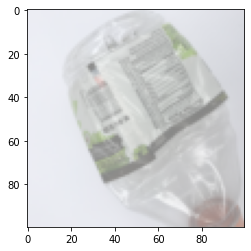

Prediction:  plastic


In [38]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(dataloader_image)
images, labels = dataiter.next()
classes = ('glass', 'plastic')

# print images
imshow(torchvision.utils.make_grid(images))
print('Prediction: ', ' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [32]:
data = next(iter(dataloader_test))

In [50]:
data[0].shape, data[1].shape

(torch.Size([32, 3, 100, 100]), torch.Size([32]))

In [55]:
example = data[0][0,:,:,:].to(device)
#plt.imshow(example)
with torch.no_grad():
  c = model(example)


tensor([[0.5298]], device='cuda:0')

In [44]:
model.load_state_dict(torch.load('model_weights12.pth'))
model.eval()

SimpleClassifier_1_hidden_layer(
  (linear1): Linear(in_features=30000, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=1, bias=True)
)